<a href="https://colab.research.google.com/github/rajibmondal/Projects.NLP/blob/master/NLP_with_Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/huggingface/transformers.git

fatal: destination path 'transformers' already exists and is not an empty directory.


In [2]:
cd transformers

/content/transformers


In [3]:
pip install .

Processing /content/transformers
  Created wheel for transformers: filename=transformers-2.3.0-cp36-none-any.whl size=459038 sha256=f17443824d0eca5c873151d75c5a3a6367b4e17e6acfd974f968c1c860fcc947
  Stored in directory: /tmp/pip-ephem-wheel-cache-7kgfzw7o/wheels/23/19/dd/2561a4e47240cf6b307729d58e56f8077dd0c698f5992216cf
Successfully built transformers
  Found existing installation: transformers 2.3.0
    Uninstalling transformers-2.3.0:
      Successfully uninstalled transformers-2.3.0


In [4]:
import pandas as pd
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

import os

import torch
import torch.optim as optim

import random 

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
train_path = '/content/drive/My Drive/NLP/NLP_DATA/ NLP with Disaster Tweets/train.csv'
test_path = '/content/drive/My Drive/NLP/NLP_DATA/ NLP with Disaster Tweets/test.csv'
sample_submission_path = '/content/drive/My Drive/NLP/NLP_DATA/ NLP with Disaster Tweets/sample_submission.csv'

In [0]:
train = pd.read_csv((train_path))


In [0]:
import pandas as pd


In [0]:
# train = pd.read_csv(str((train_path/'train.csv')))
test = pd.read_csv(test_path)
sample_submission = pd.read_csv(sample_submission_path)

In [10]:
train.shape, test.shape, sample_submission.shape

((7613, 5), (3263, 4), (3263, 2))

In [0]:


MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)
}



In [0]:
# Parameters
seed = 42
use_fp16 = False
bs = 64

model_type = 'roberta'
pretrained_model_name = 'roberta-base'

# model_type = 'bert'
# pretrained_model_name='bert-base-uncased'

# model_type = 'distilbert'
# pretrained_model_name = 'distilbert-base-uncased'

#model_type = 'xlm'
#pretrained_model_name = 'xlm-clm-enfr-1024'

#model_type = 'xlnet'
#pretrained_model_name = 'xlnet-base-cased'

In [0]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [14]:
model_class.pretrained_model_archive_map.keys()

dict_keys(['roberta-base', 'roberta-large', 'roberta-large-mnli', 'distilroberta-base', 'roberta-base-openai-detector', 'roberta-large-openai-detector'])

In [0]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [0]:
seed_all(seed)

In [0]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
        return [CLS] + tokens + [SEP]

In [0]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [0]:
class TransformersVocab(Vocab):
  def __init__(self, tokenizer: PreTrainedTokenizer):
    super(TransformersVocab, self).__init__(itos=[])
    self.tokenizer = tokenizer

  def numericalize(self, t:Collection[str]) -> List[int]:
    "Convent a list of tokens 't' to their ids. "
    return self.tokenizer.convert_tokens_to_ids(t)

  def textify(self, nums:Collection[int], sep=' ') -> List [str]:
    "Convert a list of 'nums' to their tokens"
    nums = np.array(nums).tolist()
    return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)

  def __getstate__(self):
    return {'itos':self.itos, 'tokenizer':self.tokenizer}

  def __setstate__(self, state:dict):
    self.itos = state['itos']
    self.tokenizer = state['tokenizer']
    self.stoi = collections.defaultdict(int, {v:k for k,v in enumerate(self.itos)})

In [0]:
# def __getstate__(self):
#   return {'itos':self.itos, 'tokenizer':self.tokenizer}

# def __setstate__(self, state:dict):
#   self.itos = state['itos']
#   self.tokenizer = state['tokenizer']
#   self.stoi = collections.defaultdict(int, {v:k for k,v in enumerate(self.itos)})

In [0]:
#Custom processor

transformer_vocab = TransformersVocab(tokenizer=transformer_tokenizer)
numericialize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericialize_processor]

In [0]:
 pad_first = bool(model_type in ['xlnet'])
 pad_idx = transformer_tokenizer.pad_token_id

In [23]:
# 'Salut c est moi, Hello it s me'
tokens = transformer_tokenizer.tokenize('Salut c est moi, Hello it s me')
print(tokens)
ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
print(ids)
transformer_tokenizer.convert_ids_to_tokens(ids)

['Sal', 'ut', 'Ġc', 'Ġest', 'Ġmo', 'i', ',', 'ĠHello', 'Ġit', 'Ġs', 'Ġme']
[18111, 1182, 740, 3304, 7458, 118, 6, 20920, 24, 579, 162]


['Sal', 'ut', 'Ġc', 'Ġest', 'Ġmo', 'i', ',', 'ĠHello', 'Ġit', 'Ġs', 'Ġme']

In [24]:
train[:200]

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
195,274,ambulance,|| c h i c a g o ||,when you don't know which way an ambulance is ...,1
196,276,ambulance,NaN,#reuters Twelve feared killed in Pakistani air...,1
197,277,ambulance,L. A.,http://t.co/pWwpUm6RBj Twelve feared killed in...,1
198,279,ambulance,NaN,Why is there an ambulance right outside my work,0


In [25]:
test[:5]

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [26]:
databunch = (TextList.from_df(train,cols='text', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= 'target')
             .add_test(test)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

In [27]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
databunch.show_batch()

[CLS] token : <s>
[SEP] token : </s>
[PAD] token : <pad>


text,target
<s> Ġ. : Ġ. : Ġ. : Ġ. : Ġ. : Ġ. : Ġ. : Ġ. : Ġ. : Ġ. : Ġ. : Ġ. : Ġ. : Ġ. : Ġ. : Ġ. : Ġ. : Ġ. : Ġ. : Ġ. : Ġ. : ĠRT ĠDr A yes ha 4 : Ġ# India Ko M un Tor J aw ab Do Ċ Ċ Indian ĠArmy Ġki Â ī ÃĽ _ Ġhttp,0
<s> ĠSE VER E ĠWE ATHER ĠB UL LET IN ĠNo . Ġ5 ĠFOR : ĠTY PH O ON ĠÂ ī ÃĽ Ã ı # H anna PH Â ī ÃĽ Â Ŀ Ġ( S OU D EL OR ) ĠTR OP ICAL ĠCY CL ONE : ĠWARNING ĠIS SU ED ĠAT Ġ5 : 00 ĠPM Ġ06 ... Ġhttp :// t . co / t H h j J w,1
<s> Ġ320 Ġ[ IR ] ĠIC EM O ON Ġ[ AF T ERS H OCK ] Ġ| Ġhttp :// t . co / v AM 5 PO d Gy w Ġ| Ġ@ dj ic em oon Ġ| Ġ# Dub step Ġ# T rap Music Ġ# D n B Ġ# ED M Ġ# D ance Ġ# I ces Â ī ÃĽ _ Ġhttp :// t . co / z EV ak,0
<s> Ġ320 Ġ[ IR ] ĠIC EM O ON Ġ[ AF T ERS H OCK ] Ġ| Ġhttp :// t . co / TH yz OM VW U 0 Ġ| Ġ@ dj ic em oon Ġ| Ġ# Dub step Ġ# T rap Music Ġ# D n B Ġ# ED M Ġ# D ance Ġ# I ces Â ī ÃĽ _ Ġhttp :// t . co / 83 j OO 0,0
<s> Ġ320 Ġ[ IR ] ĠIC EM O ON Ġ[ AF T ERS H OCK ] Ġ| Ġhttp :// t . co / TH yz OM VW U 0 Ġ| Ġ@ dj ic em oon Ġ| Ġ# Dub step Ġ# T rap Music Ġ# D n B Ġ# ED M Ġ# D ance Ġ# I ces Â ī ÃĽ _ Ġhttp :// t . co / 83 j OO 0,0


In [28]:
print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', pad_idx)


[CLS] id : 0
[SEP] id : 2
[PAD] id : 1


In [29]:
test_one_batch = databunch.one_batch()[0]
print('Batch shape:', test_one_batch.shape)
print(test_one_batch)

Batch shape: torch.Size([64, 86])
tensor([[    0,   479,    35,  ...,   306,   571,     2],
        [    0, 21947,   646,  ...,     1,     1,     1],
        [    0, 21947,   646,  ...,     1,     1,     1],
        ...,
        [    0,   128, 14696,  ...,     1,     1,     1],
        [    0, 14826,   787,  ...,     1,     1,     1],
        [    0,  5505, 23171,  ...,     1,     1,     1]])


In [0]:
# defining our model architecture
class CustomTransformerModel(nn.Module):
  def __init__(self, transformer_model:PreTrainedModel):
    super(CustomTransformerModel, self).__init__()
    self.transformer = transformer_model

  def forward(self, input_ids, attention_mask=None):
    #attention_mask = (input_ids!=1).type(input_ids.type()) # Test attention_mask for RoBERTa

    logits = self.transformer(input_ids, attention_mask=attention_mask)[0]


    return logits



In [31]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 2
config.use_bfloat16 = use_fp16
print(config)

RobertaConfig {
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "do_sample": false,
  "eos_token_ids": 0,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-05,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_beams": 1,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_token_id": 0,
  "pruned_heads": {},
  "repetition_penalty": 1.0,
  "temperature": 1.0,
  "top_k": 50,
  "top_p": 1.0,
  "torchscript": false,
  "type_vocab_size": 1,
  "use_bfloat16": false,
  "vocab_size": 50265
}



In [0]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config=config)
# transformer_model = model_class.from_pretrained(pretrained_model_name, num_labels = 5)

custom_transformer_model = CustomTransformerModel(transformer_model=transformer_model)

In [0]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial


CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch,
                  custom_transformer_model,
                  opt_func=CustomAdamW,
                  metrics=[accuracy, error_rate])

#Show graph of learner states and metrics after epoch.
learner.callbacks.append(ShowGraph(learner))

#Put learn in FP16 precession mode.--> Seems to not working
if use_fp16:learner = learner.to_fp16



In [34]:
print(learner.model)

CustomTransformerModel(
  (transformer): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(i

In [0]:
# # For DistilBERT
# list_layers = [learner.model.transformer.distilbert.embeddings,
#                learner.model.transformer.distilbert.transformer.layer[0],
#                learner.model.transformer.distilbert.transformer.layer[1],
#                learner.model.transformer.distilbert.transformer.layer[2],
#                learner.model.transformer.distilbert.transformer.layer[3],
#                learner.model.transformer.distilbert.transformer.layer[4],
#                learner.model.transformer.distilbert.transformer.layer[5],
#                learner.model.transformer.pre_classifier]

# For roberta-base
list_layers = [learner.model.transformer.roberta.embeddings,
              learner.model.transformer.roberta.encoder.layer[0],
              learner.model.transformer.roberta.encoder.layer[1],
              learner.model.transformer.roberta.encoder.layer[2],
              learner.model.transformer.roberta.encoder.layer[3],
              learner.model.transformer.roberta.encoder.layer[4],
              learner.model.transformer.roberta.encoder.layer[5],
              learner.model.transformer.roberta.encoder.layer[6],
              learner.model.transformer.roberta.encoder.layer[7],
              learner.model.transformer.roberta.encoder.layer[8],
              learner.model.transformer.roberta.encoder.layer[9],
              learner.model.transformer.roberta.encoder.layer[10],
              learner.model.transformer.roberta.encoder.layer[11],
              learner.model.transformer.roberta.pooler]

# # # For BERT
# list_layers = [learner.model.transformer.bert.embeddings,
#                learner.model.transformer.bert.transformer.layer[0],
#                learner.model.transformer.bert.transformer.layer[1],
#                learner.model.transformer.bert.transformer.layer[2],
#                learner.model.transformer.bert.transformer.layer[3],
#                learner.model.transformer.bert.transformer.layer[4],
#                learner.model.transformer.bert.transformer.layer[5],
#                learner.model.transformer.pre_classifier]



In [36]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in', num_groups, 'groups')
print(learner.layer_groups)

Learner split in 14 groups
[Sequential(
  (0): Embedding(50265, 768, padding_idx=1)
  (1): Embedding(514, 768, padding_idx=1)
  (2): Embedding(1, 768)
  (3): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (4): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=768, out_features=768, bias=True)
  (5): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=768, out_features=3072, bias=True)
  (8): Linear(in_features=3072, out_features=768, bias=True)
  (9): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (10): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2)

####Train

In [0]:
learner.save('untrain')

In [0]:
seed_all(seed)
learner.load('untrain');

In [0]:
learner.freeze_to(-1)

In [40]:
learner.summary()

CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [86, 768]            38,603,520 False     
______________________________________________________________________
Embedding            [86, 768]            394,752    False     
______________________________________________________________________
Embedding            [86, 768]            768        False     
______________________________________________________________________
LayerNorm            [86, 768]            1,536      False     
______________________________________________________________________
Dropout              [86, 768]            0          False     
______________________________________________________________________
Linear               [86, 768]            590,592    False     
______________________________________________________________________
Linear               [86, 768]            590,592    False     
_______________________________________

In [41]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.31E-04
Min loss divided by 10: 3.98E-05


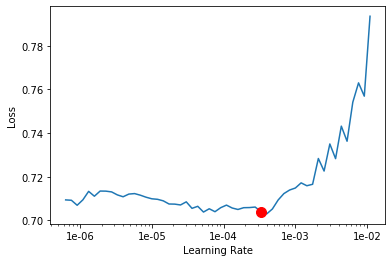

In [42]:
learner.recorder.plot(skip_end=10, suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.587357,0.478331,0.766097,0.233903,00:17


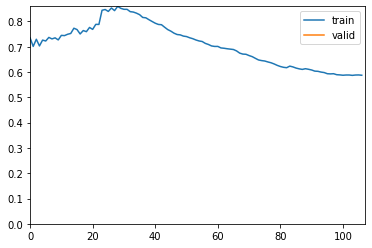

In [43]:
learner.fit_one_cycle(1, max_lr=2e-03, moms=(0.8, 0.7))

In [0]:
learner.save('first_cycle')

In [0]:
seed_all(seed)
learner.load('first_cycle');

In [0]:
learner.freeze_to(-2)
lr = 1e-5

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.480170,0.422294,0.821288,0.178712,00:21


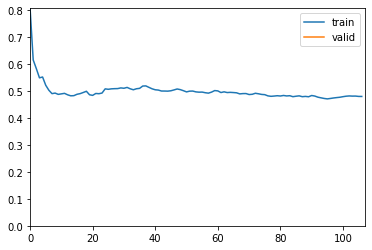

In [47]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [0]:
learner.save('second_cycle')

In [0]:
seed_all(seed)
learner.load('second_cycle');

In [0]:
learner.freeze_to(-3)


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.443287,0.412014,0.827858,0.172142,00:25


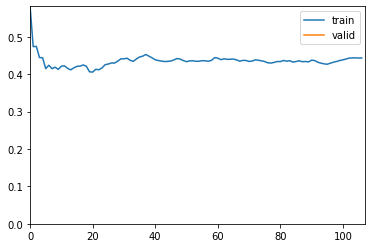

In [51]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [0]:
learner.save('third_cycle')

In [0]:
seed_all(seed)
learner.load('third_cycle');

In [0]:
learner.unfreeze()

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.422472,0.396298,0.831800,0.168200,00:58
1,0.356796,0.389670,0.847569,0.152431,00:57


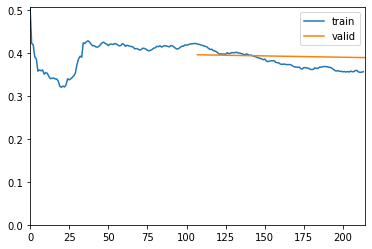

In [55]:
learner.fit_one_cycle(2, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))